In [1]:
import os 
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import numpy as np
import math
import matplotlib.patches as patches
from scipy.spatial.distance import pdist
from scipy.spatial import distance_matrix

In [2]:
fp = './1_ANALYSIS/PL/'
pucks = {
'SW6':  fp + "SW6_jun14_pl.csv",
'F03':  fp + "F03_jun14_pl.csv",
'SW30':  fp + "SW30_jun14_pl.csv",
'SW31':  fp + "SW31_jun14_pl.csv",
'SW33':  fp + "SW33_jun14_pl.csv",
'SW55':  fp + "SW55_jun14_pl.csv",
'SW56':  fp + "SW56_jun14_pl.csv",
}
for p in pucks:
    pucks[p] = pd.read_csv(pucks[p],index_col=0)

In [3]:
fp = './1_ANALYSIS/BC/'
selbc = {}
outf = 'bc_apr_1'
for p in pucks.keys():
    selbc[p] = [x.strip() for x in open(fp + f'{p}_{outf}.csv','r').readlines()]
    pucks[p] = pucks[p].assign(sel = 0)
    pucks[p].loc[pucks[p].index.isin(selbc[p]),'sel'] = 1
    

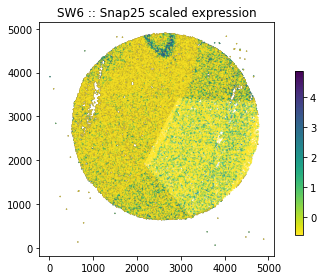

In [4]:
plt.rcParams["figure.figsize"] = (8,8)
gene = 'Snap25'
for p in pucks:
    if p!='SW6':
        continue
    fig, ax = plt.subplots()
    ax.scatter(pucks[p].x, pucks[p].y, c = pucks[p].sel, cmap = 'hot',s=.1)
    neg = ax.scatter(pucks[p].x, pucks[p].y, c = pucks[p][gene],s=.1,cmap='viridis_r')
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(f'{p} :: Snap25 scaled expression')
    fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
    plt.tight_layout()
#     plt.savefig('/Users/gas361/Desktop/SW6_snap25.pdf')
    


In [5]:
pldfs = {}
path = './1_ANALYSIS/PLDF/'
for x in os.listdir(path):
    if 'csv' not in x:
        continue
    p = x.split('_')[0]
    pldfs[p] = pd.read_csv(f'{path}{x}', header=0, index_col=0)

In [6]:
exc_scheme = {'L2':'#EEEEEE','L2_3':'#EEEEEE',
             'L4':'#999999','L4_5':'#999999',
             'L5':'#555666','L5_6':'#555666',
             'L6':'#111111',
             'L6b':'#000000'}

sst_order = ['Sst Mme', 'Sst Calb2','Sst Hpse', 'Sst Etv1','Sst Myh8','Sst Syndig1l', 'Sst Crh','Sst Nmbr',
             'Sst Chodl','CHODL']


sst_scheme = {
'Sst Mme': '#08BD71',
'Sst Calb2': '#B99E00',
'Sst Hpse': '#75AF04',
'Sst Etv1': '#00BDCD',
'Sst Myh8': '#F562DE',
'Sst Syndig1l': '#06C0A4',
'Sst Crh': '#8FA903',
'Sst Nmbr': '#0AB2EE',
'Sst Chodl': '#C07FFF',
'CHODL': '#C07FFF'}

In [7]:
excs = {}
for p in pldfs:
    pldfs[p] = pldfs[p][~pldfs[p].id.isin(['VLMC'])]
    pldfs[p] = pldfs[p].assign(mark=0)
    tmp = pldfs[p][pldfs[p].my_t=='EXC'].copy()
    tmp.L = tmp.L.replace('L6_b','L6b')
    tmp = tmp.assign(c = [ exc_scheme[x] for x in tmp['L']])
    tmp = tmp.assign(neb_1='', neb_2='',cnt_1=0, cnt_2=0, mark=1)
    excs[p] = tmp.copy()

In [8]:
def top_neb(exc, limit_index):
    tmp = pd.DataFrame(distance_matrix(exc[['x', 'y']], exc[['x', 'y']], p=2))
    tmp.index = exc.index
    tmp.columns = exc.index
    res = tmp.apply(lambda x: x.nsmallest(n=21).index.to_list(), axis=1)
    res = pd.DataFrame(res)
    res.columns = ['neb']
    res.index = exc.index
    res.index = res.index.rename('bc')
    
    for x in res[exc.my_t.eq(limit_index)].index:
        ix = res.loc[x]
        neb = exc.loc[ix.to_list()[0]].L.value_counts()
        ls = neb.index.to_list()
        neb = neb.values
        exc.loc[x,'neb_1'] = ls[0]
        exc.loc[x,'cnt_1'] = neb[0]
        if len(ls)>1:
            exc.loc[x,'neb_2'] = ls[1]
            exc.loc[x,'cnt_2'] = neb[1]

    return exc

def rotate_plot(tpl, theta=180):
    theta = math.radians(theta)
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta), np.cos(theta)]])
    tplp = np.dot(tpl[['x','y']],R)
    tplp = pd.DataFrame(tplp)
    tplp.columns = ['x','y']
    tpl = tpl.assign(rx = tplp.x.tolist())
    tpl = tpl.assign(ry = tplp.y.tolist())
    return(tpl)

In [9]:
sst_dfs = {}
for p in pldfs:
    exc = top_neb(excs[p],'EXC')
    exc.loc[exc[exc.L != exc.neb_1].index,'mark'] = 2
    
    pldfs[p].loc[exc.index,'mark'] = exc.mark
    excs[p] = exc.copy()
    
    sst_df = pldfs[p][pldfs[p].my_t.isin(['SST','EXC']) & pldfs[p].mark.ne(2)].copy()
    sst_df = sst_df.assign(neb_1='', neb_2='',cnt_1=0, cnt_2=0)
    sst_df = top_neb(sst_df, 'SST')
    sst_dfs[p] = sst_df.copy()
    

In [12]:
sst_pls = {}
for p in pldfs:
    sst_df = sst_dfs[p].copy()
    sst_df = sst_df[sst_df.my_t.eq('SST')]
    sst_df = sst_df.assign(c=[sst_scheme[x] for x in sst_df.id.to_list()])
    sst_df.id = sst_df.id.replace('Sst-Chodl','CHODL').replace('Sst Chodl','CHODL')
    mask = sst_df.cnt_1.ge(sst_df.cnt_2)
    sst_df.loc[mask, 'L'] = sst_df.loc[mask, 'neb_1']
    sst_df.loc[~mask,'L'] = sst_df.loc[~mask,'neb_2']
    sst_df.L = sst_df.L.replace('L2','L2_3')
    sst_pls[p] = sst_df.copy()

In [13]:
sst_order = ['Sst Mme', 'Sst Calb2','Sst Hpse', 'Sst Etv1','Sst Myh8',
             'Sst Syndig1l', 'Sst Crh','Sst Nmbr','CHODL']

for p in pldfs:
    pldfs[p] = pldfs[p].assign(Sst_umi=0)
    
    sst_pl = sst_pls[p].copy()
    sst_pl = sst_pl[sst_pl.index.isin(pucks[p].index[pucks[p].sel.eq(1)])]

    sst_pl.id = sst_pl.id.astype("category")
    sst_pl.id = sst_pl.id.cat.set_categories(sst_order, ordered=True)
    sst_pls[p] = sst_pl.copy()
    pldfs[p].loc[pldfs[p].index.isin(sst_pl.index),'Sst_umi'] = pucks[p][pucks[p].index.isin(sst_pl.index)].Sst_umi


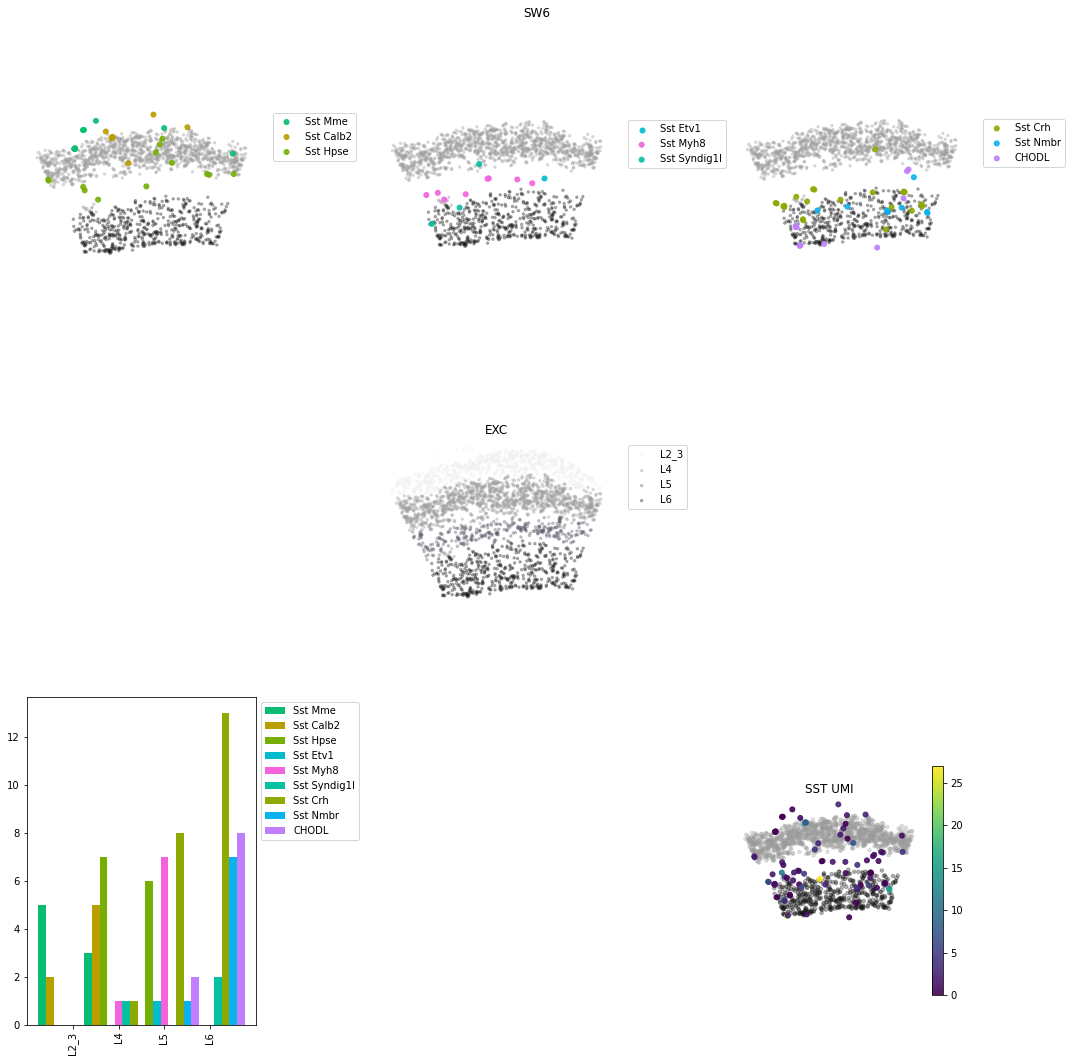

In [14]:
cs = 3
rs = 3
rot_a = {'SW6': -120,'SW55':135, 'SW31':-10, 'SW30':-90, 'F03':-180, 'SW56':-40, 'SW33' :-85}
plt.rcParams["figure.figsize"] = (15,15)
exc_s = 6
excl = ['L4','L6']

for p in pucks.keys():
    if p!='SW6':
        continue
    plt.figure()
    
    # get plottings dfs for SST, and EXC 
    sst_pl = sst_pls[p].copy()
    exc = excs[p]
    # fix the EXC Layers
    exc = exc[exc.index.isin(pucks[p].index[pucks[p].sel.eq(1)])].copy()
    exc.L = exc.L.replace('L6b','L6')
    exc.L = exc.L.replace('L2','L2_3')
    exc.L = exc.L.replace('L4_5','L4')
    exc.L = exc.L.replace('L5_6','L5')
    exc.L = exc.L.astype("category")
    exc.L = exc.L.cat.set_categories(['L2_3','L4','L5','L6'], ordered=True)

    plt.suptitle(p)
    inc = 0 
    
    # build 3 plots with SST cells 
    for n, ct in enumerate(sst_pl.id.cat.categories):
        if n%3 ==0:
            ax = plt.subplot(rs, cs, inc + 1)
            inc += 1
            #include EXC L4 and L6 for reference
            for e in excl:
                # keep only selected cells
                tpl = exc[exc.L.eq(e) & exc.mark.eq(1)]
                # rotate the puck to proper orientation
                tpl = rotate_plot(tpl, rot_a[p])
                ax.scatter(x=tpl.rx, y=tpl.ry,s=exc_s,c=tpl.c,alpha=.3)

        
        tpl = sst_pl[sst_pl.id.eq(ct)]
        tpl = rotate_plot(tpl, rot_a[p])
        ax.scatter(x=tpl.rx, y=tpl.ry,s=25,c=tpl.c,alpha=.9, label = ct)
        ax.axis('scaled')
        ax.axis('off')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # build plot with ALL layers EXC only
    ax = plt.subplot(rs, cs, 5)
    for e in exc.L.cat.categories.values:
        tpl = exc[exc.L.eq(e) & exc.mark.eq(1)]
        tpl = rotate_plot(tpl, rot_a[p])
        ax.scatter(x=tpl.rx, y=tpl.ry,s=exc_s,c=tpl.c,alpha=.3, label = e)
        ax.set_title('EXC')
        ax.axis('scaled')
        ax.axis('off')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


    # bar plot of sst types by layers
    ax = plt.subplot(rs, cs, 7)
    tmppl = sst_pl
    tmppl.L = tmppl.L.replace('L6b','L6')
    tmppl = pd.crosstab(tmppl.L, tmppl.id)
    tmppl.plot(kind='bar',stacked=False, ax=ax, color = sst_scheme,width=1.5)
    ax.legend(bbox_to_anchor=(1,1), loc="upper left")
    ax.set_xlabel('')


    # plot of SST umis 
    tf = pucks[p][pucks[p].index.isin(sst_pl.index)].Sst_umi
    sst_pl.loc[tf.index,'Sst_umi'] =  tf.values
    sstu = pldfs[p][pldfs[p].Sst_umi.ge(1)]
    ax = plt.subplot(rs, cs, 9)

    for e in excl:
        tpl = exc[exc.L.eq(e) & exc.mark.eq(1)]
        tpl = rotate_plot(tpl, rot_a[p])
        ax.scatter(x=tpl.rx, y=tpl.ry,s=12,c=tpl.c,alpha=.3, label = e)

    tpl = sst_pl
    tpl = rotate_plot(tpl, rot_a[p])
    neg = ax.scatter(x=tpl.rx, y=tpl.ry,s=25,c=tpl.Sst_umi,alpha=.9, label = 'SST UMI',cmap='viridis')
    ax.set_title('SST UMI')
    ax.axis('scaled')
    ax.axis('off')
    fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
    plt.tight_layout()



In [21]:
plt.close('all')

for p in sst_pls.keys():
    sst_pls[p] = sst_pls[p].assign(puck=p)

boxer_a = pd.concat([sst_pls[p][['puck','id','L']] for p in sst_pls.keys()])
boxer_a.to_csv('./1_ANALYSIS/boxer_a.csv')
